Before running the following notebook, make sure to set the variables in the configuration file `python/config_paths_and_variables.sh`, following the indications provided by the description. Also, extract the lines (and therefore, generate the textfiles containing them) for the frames for which you want to visualize the data.

In [1]:
## Import
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import open3d 
%matplotlib inline

In [2]:
import sys

python_root = '../'
sys.path.insert(0, python_root)

from tools import cloud_utils
from tools import get_protobuf_paths
from tools import pathconfig
from tools import scenenet_utils
from tools import virtual_camera_utils

scenenet_utils.py: Using value in config_paths_and_variables.sh for SCENENET_SCRIPTS_PATH.


# Camera info

In [3]:
# Virtual camera is of the SceneNetRGBD (pinhole) camera model.
virtual_camera = scenenet_utils.get_camera_model()
# Camera from which the images were taken, SceneNetRGBD (pinhole) camera model.
real_camera = scenenet_utils.get_camera_model()

# Read data
The SceneNetRGBD dataset has different sets, each associated to protobuf (.pb) file and each containing 1000 trajectories. In particular, it contains one validation set (associated protobuf file <tt>scenenet_rgbd_val.pb</tt>) and 17 training sets (associated protobuf files <tt>train_protobufs/scenenet_rgbd_train_`set_index`.pb</tt>, with `set_index` in {0..16}). The images for each dataset are stored under <tt>data/train/`set_index`/`trajectory_key`</tt> for the training sets and under <tt>data/val/`set_index`/`trajectory_key`</tt> for the validation set.
However, the trajectory with index `trajectory_index` does not have a `trajectory_key` equal to `trajectory_index`, and cannot therefore be simply found under <tt>data/`dataset_type`/`set_index`/`trajectory_key`</tt>.
The `trajectory_key` for the trajectory with index `trajectory_index` is stored in the protobuf file, where the intermediate path `set_index`/`trajectory_key` is referred to as <i>render path</i>.
Protobuf files also contains information about the camera, such as the camera-to-world transformation matrix.


In [4]:
# Dataset name. For SceneNetRGBD valid values are 'val' or 'train_NUM', where NUM is a number between 0 and 16.
# Other valid names are 'scenenn', for dataset SceneNN.
dataset_name = 'train_0'
# Index of the trajectory for which to read data.
trajectory = 1
# Frame from which the lines to be shown were extracted.
frame_id = 0

# Path of the protobuf file associated to the dataset.
protobuf_path = get_protobuf_paths.get_protobuf_path(dataset_name)

# Path containing the SceneNetRGBD dataset.
scenenet_dataset_path = pathconfig.obtain_paths_and_variables(
                "SCENENET_DATASET_PATH")
# Subfolder containing the data for the specified dataset from SceneNetRGBD.
dataset_path = os.path.join(scenenet_dataset_path, 'data/',
                            dataset_name.split('_')[0])

# Path containing the lines extracted and the virtual-camera images.
linesandimagesfolder_path = pathconfig.obtain_paths_and_variables(
            "LINESANDIMAGESFOLDER_PATH")
# Subfolder containing the line textfiles.
linesfiles_path = os.path.join(linesandimagesfolder_path,
                                   '{}_lines'.format(dataset_name))
# Subfolder containing the line textfiles for the specified trajectory.
path_to_lines_root = os.path.join(linesfiles_path, 'traj_{0}/'.format(trajectory))

# Path containing the modules from pySceneNetRGBD.
scenenetscripts_path = pathconfig.obtain_paths_and_variables("SCENENET_SCRIPTS_PATH")
sys.path.append(scenenetscripts_path)
import scenenet_pb2 as sn
   
# Read data from the protobuf file.
trajectories = sn.Trajectories()
try:
    with open(protobuf_path, 'rb') as f:
        trajectories.ParseFromString(f.read())
except IOError:
    print('Scenenet protobuf data not found at location:{0}. '.format(protobuf_path) +
          'Please ensure you have copied the pb file to the data directory.')
    
# Extract the render path from the data read from the protobuf file.    
traj_renderpath = trajectories.trajectories[trajectory].render_path

# Retrieve the location of the images on the disk.
path_to_photos = os.path.join(dataset_path, traj_renderpath)
    
# To comply with the format of the filenames from SceneNetRGBD.    
photo_id = frame_id * 25

# Path to line textfiles containing the info for the lines detected in the frame being considered.
path_to_lines = os.path.join(path_to_lines_root, 'lines_with_labels_{0}.txt'.format(frame_id))
path_to_lines_2D_kept = os.path.join(path_to_lines_root,
                             'lines_2D_kept_{0}.txt'.format(frame_id))
path_to_lines_2D = os.path.join(path_to_lines_root,
                             'lines_2D_{0}.txt'.format(frame_id))

# Read the data from the line textfiles.
try:
    data_lines = pd.read_csv(path_to_lines, sep=" ", header=None)
except (IOError, pd.io.common.EmptyDataError):
    print("No line detected for frame {}".format(frame_id))
            
data_lines = data_lines.values
lines_count = data_lines.shape[0] 
print('Number of lines detected: {}'.format(lines_count))

data_lines_2D_kept = pd.read_csv(path_to_lines_2D_kept, sep=" ", header = None)
data_lines_2D_kept = data_lines_2D_kept.values
data_lines_2D_kept = data_lines_2D_kept.astype(np.int16)

data_lines_2D = pd.read_csv(path_to_lines_2D, sep=" ", header = None)
data_lines_2D = data_lines_2D.values
data_lines_2D = data_lines_2D.astype(np.int16)

assert lines_count == data_lines_2D_kept.shape[0]

# Read images.
rgb_image = cv2.imread(
            os.path.join(path_to_photos,'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)

depth_image = cv2.imread(
            os.path.join(path_to_photos,'depth/{0}.png'.format(photo_id)), cv2.IMREAD_UNCHANGED)

instance_image = cv2.imread(
            os.path.join(path_to_photos,'instance/{0}.png'.format(photo_id)), cv2.IMREAD_UNCHANGED)

Number of lines detected: 81


# Get pointcloud from the RGB-D image

In [5]:
# Obtain coloured point cloud from RGB-D image.
pcl = real_camera.rgbd_to_pcl(rgb_image=rgb_image, depth_image=depth_image, visualize_cloud=False)

CPU times: user 411 ms, sys: 576 ms, total: 987 ms
Wall time: 230 ms


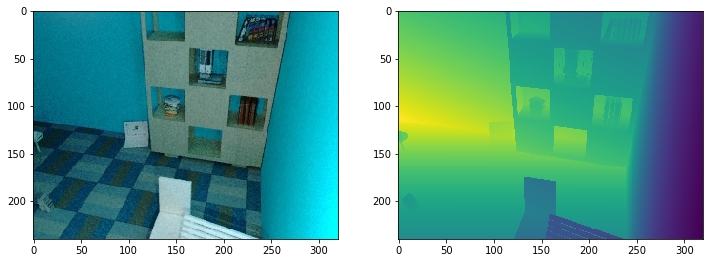

In [6]:
%%time
plt.rcParams['figure.figsize'] = (12, 12) 

# As a check, show the RGB and depth images obtained by reprojecting the point cloud onto the image plane of the
# real camera. NOTE: The point cloud generated above has obviously coordinates in the world frame.
(rgb_image_from_pcl, depth_image_from_pcl, num_nonempty_pixels) = cloud_utils.project_pcl_to_image(pcl, real_camera)
fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(rgb_image_from_pcl, cv2.COLOR_BGR2RGB))
ax[1].imshow(depth_image_from_pcl)

# Compare all lines detected in 2D and kept lines

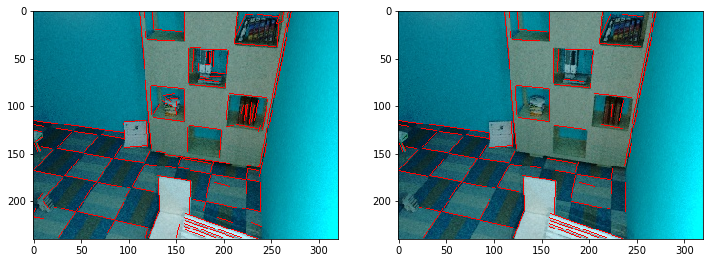

In [7]:
rgb_image_2D = cv2.imread(
            os.path.join(path_to_photos, 'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)
rgb_image_2D_kept = cv2.imread(
            os.path.join(path_to_photos, 'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)

# Overlap all the initially-detected 2D lines on the left image.
for i in range(data_lines_2D.shape[0]):
    cv2.line(rgb_image_2D, tuple(data_lines_2D[i][:2]), tuple(data_lines_2D[i][2:]), (0,0,255), 1)
    
# Overlap all the 2D lines kept on the right image.    
for i in range(data_lines_2D_kept.shape[0]):
    cv2.line(rgb_image_2D_kept, tuple(data_lines_2D_kept[i][:2]), tuple(data_lines_2D_kept[i][2:]), (0,0,255), 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(rgb_image_2D,cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(rgb_image_2D_kept,cv2.COLOR_BGR2RGB))

# Draw lines and pointcloud

In [8]:
from tools.visualization import pcl_lines_for_plot

pcl_open3d =  open3d.PointCloud()
pcl_open3d.points = open3d.Vector3dVector(pcl[:,:3])
pcl_open3d.colors = open3d.Vector3dVector(pcl[:,[5,4,3]] / 255)

# Color line according to its type:
# - green -> planar line;
# - red -> discontinuity line;
# - blue -> edge line;
# - yellow -> intersection line.
pcl_lines_open3d = pcl_lines_for_plot(data_lines[:], data_lines[:,-2], 'open3d')
pcl_lines_open3d.append(pcl_open3d)
open3d.draw_geometries(pcl_lines_open3d[:])

visualization.py: Using values in config_paths_and_variables.sh for SCENENET_SCRIPTS_PATH, LINESANDIMAGESFOLDER_PATH.


# Virtual-camera image for a line

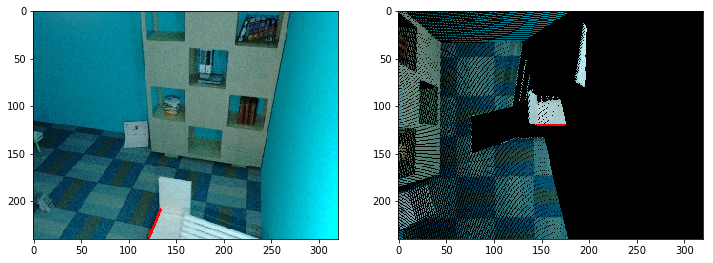

In [9]:
# ID of the line in the frame.
i = 1
# Distance of the virtual camera image from the center of the line.
distance = 3

# Obtain the pose of the virtual camera.
T, z = virtual_camera_utils.virtual_camera_pose_from_file_line(data_lines[i,:], distance)

# Transform the point cloud so as to make it appear as seen from the virtual camera pose.
pcl_from_line_view = cloud_utils.pcl_transform(pcl, T)

# Obtain the RGB and depth virtual camera images by reprojecting the point cloud on the image plane,
# under the view of the virtual camera. Also obtain the number of nonempty pixels.
(rgb_image_from_line_view, depth_image_from_line_view,
     num_nonempty_pixels) = cloud_utils.project_pcl_to_image(pcl_from_line_view, virtual_camera)

start_point = data_lines[i, :3]
end_point = data_lines[i, 3:6]
middle_point = (start_point + end_point) / 2  

pcl_line = np.vstack((start_point, end_point))
pcl_line = np.hstack((pcl_line, np.array([[0, 0, 255], [0, 0, 255]])))

# Transform the point cloud so as to make it appear as seen from the virtual camera pose.
pcl_line_new = cloud_utils.pcl_transform(pcl_line, T)

# Draw the line on the virtual-camera image (shown on the right).
cv2.line(rgb_image_from_line_view, (int(virtual_camera.project3dToPixel(pcl_line_new[0, :3])[0]), \
                                    int(virtual_camera.project3dToPixel(pcl_line_new[0, :3])[1])), \
                                   (int(virtual_camera.project3dToPixel(pcl_line_new[1, :3])[0]), \
                                    int(virtual_camera.project3dToPixel(pcl_line_new[1, :3])[1])), (0, 0, 255), 2)

# As a comparison, show on the left the original image, with the detected 2D line.
rgb_image = cv2.imread(
            os.path.join(path_to_photos,'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)

cv2.line(rgb_image, (int(real_camera.project3dToPixel(pcl_line[0, :3])[0]), \
                     int(real_camera.project3dToPixel(pcl_line[0, :3])[1])), \
                    (int(real_camera.project3dToPixel(pcl_line[1, :3])[0]), \
                     int(real_camera.project3dToPixel(pcl_line[1, :3])[1])), (0, 0, 255), 2)

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(rgb_image,cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(rgb_image_from_line_view,cv2.COLOR_BGR2RGB))

# Inpainting 

The empty pixels in the virtual-camera images (due to viewpoint change, occlusions, etc.) can be coloured by _impainting_ them, i.e. by deducing their colour based on the colour of the nearbying pixels. This process, however, has a high computational cost.

CPU times: user 814 ms, sys: 13.6 ms, total: 827 ms
Wall time: 805 ms


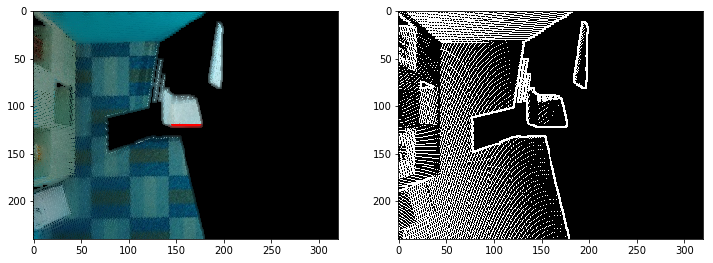

In [10]:
%%time
# Inpaint the virtual camera image.
plt.rcParams['figure.figsize'] = (12, 12)
reds = rgb_image_from_line_view[:, :, 2]
greens = rgb_image_from_line_view[:, :, 1]
blues = rgb_image_from_line_view[:, :, 0]

mask = ((greens != 0) | (reds != 0) | (blues != 0)) * 1
mask = np.array(mask, dtype=np.uint8)

kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(mask, kernel, iterations=1) - mask

rgb_image_from_line_view = cv2.inpaint(rgb_image_from_line_view, dilated_mask, 10, cv2.INPAINT_TELEA)
depth_image_from_line_view = cv2.inpaint(depth_image_from_line_view, dilated_mask, 10, cv2.INPAINT_TELEA)

permutation = np.argsort([2,1,0])
fig, ax = plt.subplots(1,2)
    
ax[0].imshow(rgb_image_from_line_view[:,:,permutation])
ax[1].imshow(dilated_mask, cmap='gray')